In [1]:
import pandas as pd

In [2]:
import os

In [3]:
from sklearn.linear_model import LinearRegression

In [4]:
import matplotlib.pyplot as plt

In [5]:
import requests

In [6]:
import json

In [7]:
import re

In [8]:
from bs4 import BeautifulSoup

In [9]:
def create_dir_if_not_exists(rel_dir_path):
    if not os.path.exists(rel_dir_path):
        os.makedirs(rel_dir_path)

In [10]:
create_dir_if_not_exists('dataset')

In [11]:
create_dir_if_not_exists('predicted-dataset')

In [12]:
usd_to_INR_exchange_rate_url = 'https://api.exchangerate.host/latest?source=ecb&base=USD&symbols=INR'

In [13]:
usd_to_INR_exchange_rate_json = requests.get(usd_to_INR_exchange_rate_url).json()

In [14]:
usd_to_INR_exchange_rate = float(usd_to_INR_exchange_rate_json['rates']['INR'])

In [15]:
catalyst_url = 'https://catalystcloud.nz/services/iaas/compute'

In [16]:
catalyst_data_location = 'dataset/catalyst_price_data.csv'

In [17]:
catalyst_gst_exclusive = True

In [18]:
catalyst_price_page_html = requests.get(catalyst_url).text 

In [19]:
catalyst_price_page = BeautifulSoup(catalyst_price_page_html, 'html.parser')

In [20]:
catalyst_price_table = catalyst_price_page.find(attrs={'class': 'service-price-table'}).tbody

In [21]:
catalyst_price_rows = catalyst_price_table.find_all('tr')

In [22]:
catalyst_prices_list = []

In [23]:
for row in catalyst_price_rows:
    catalyst_price_cells = list(row.stripped_strings)
    
    catalyst_prices_list.append({
        'Name': catalyst_price_cells[0],
        'vCPU': float(catalyst_price_cells[1]),
        'RAM, GB': float(catalyst_price_cells[2]),
        'Price per hour, INR (ex GST)': float(catalyst_price_cells[3].strip('$')),
        'SSD storage, GB': .0,
        'HDD storage, GB': .0
    })

In [24]:
catalyst_dataframe = pd.DataFrame(catalyst_prices_list)

In [25]:
catalyst_dataframe.to_csv(catalyst_data_location)

In [26]:
print('Downloaded Catalyst prices, with {} items.'.format(catalyst_dataframe.shape[0]))

Downloaded Catalyst prices, with 45 items.


In [27]:
aws_url = 'https://pricing.us-east-1.amazonaws.com/offers/v1.0/aws/AmazonEC2/current/ap-southeast-2/index.json'

In [28]:
aws_raw_location = 'dataset/raw_aws_bulk.json'

In [29]:
aws_acceptable_instance_families = [
    'General purpose',
    'Micro instances'
]

In [30]:
aws_data_location = 'dataset/aws_price_data.csv'

In [31]:
aws_gst_exclusive = True

In [32]:
aws_bulk_json_request = requests.get(aws_url)

In [33]:
aws_bulk_json = aws_bulk_json_request.json()

In [34]:
with open(aws_raw_location, 'w') as aws_raw_file:
    json.dump(aws_bulk_json, aws_raw_file)

In [35]:
with open(aws_raw_location, 'r') as aws_raw_file:
    aws_raw_json = json.load(aws_raw_file)
        
    aws_instances_list = []
            
    for product in aws_raw_json['products']:
        
        productFamily = aws_raw_json['products'][product]['productFamily']
        
        
        if productFamily == 'Compute Instance':
                        
            
            instanceFamily = aws_raw_json['products'][product]['attributes']['instanceFamily']
            is_current_gen = aws_raw_json['products'][product]['attributes']['currentGeneration'] == 'Yes'
            is_linux = aws_raw_json['products'][product]['attributes']['operatingSystem'] == 'Linux'
            no_preInstalledSw = aws_raw_json['products'][product]['attributes']['preInstalledSw'] == 'NA'
            is_shared_instance = aws_raw_json['products'][product]['attributes']['tenancy'] == 'Shared'

            if instanceFamily in aws_acceptable_instance_families and is_current_gen \
                and is_linux and no_preInstalledSw and is_shared_instance:
                
                
                aws_instances_list.append(product)

In [36]:
with open(aws_raw_location, 'r') as aws_raw_file:
    
    aws_prices_list = []
    
    for instance_key in aws_instances_list:

        attributes = aws_raw_json['products'][instance_key]['attributes']
                    
        
        vCPU = float(attributes['vcpu'].replace(',',''))
        RAM = float(attributes['memory'].split(' ')[0].replace(',',''))

        
        storage_strings = attributes['storage'].split(' ')

        
        final_num_index = None
        for word in storage_strings[::-1]:
            try:
                float(word.replace(',', ''))
                final_num_index = storage_strings.index(word)
                break
            except:
                foo = None

        
        if final_num_index == None:
            total_ssd = .0
            total_hdd = .0
        else:

            
            storage_calcs = storage_strings[0:final_num_index+1]
            storage_volume = eval(' '.join(['*' if x=='x' else x.replace(',', '') for x in storage_calcs]))

            
            if 'HDD' in storage_strings:                        
                total_ssd = .0
                total_hdd = float(storage_volume)

            elif 'SSD' in storage_strings:                        
                total_ssd = float(storage_volume)
                total_hdd = .0
            else: 
                total_ssd = float(storage_volume)
                total_hdd = .0


        
        terms = aws_raw_json['terms']['OnDemand'][instance_key]
        usd_price = None
        for specific_term in terms:
            for dimension_key in terms[specific_term]['priceDimensions']:
                dimension = terms[specific_term]['priceDimensions'][dimension_key]
                if dimension['unit'] != 'Hrs': raise ValueError("This price isn't in hours")
                usd_price = float(dimension['pricePerUnit']['USD'])

        
        INR_price = usd_price * usd_to_INR_exchange_rate
                
        
        aws_prices_list.append({
            'Name': attributes['instanceType'],
            'vCPU': vCPU,
            'RAM, GB': RAM,
            'Price per hour, INR (ex GST)': INR_price,
            'SSD storage, GB': total_ssd,
            'HDD storage, GB': total_hdd
        })






In [37]:
aws_dataframe = pd.DataFrame(aws_prices_list)

In [38]:
aws_dataframe.to_csv(aws_data_location)

In [39]:
print('Downloaded AWS prices, with {} items.'.format(aws_dataframe.shape[0]))

Downloaded AWS prices, with 279 items.


In [40]:
azure_url = 'https://azure.microsoft.com/en-us/pricing/details/virtual-machines/linux/'

In [41]:
azure_data_location = 'dataset/azure_price_data.csv'

In [42]:
azure_acceptable_categories = [
    'general-purpose-filter'
]

In [43]:
azure_acceptable_regions = [
    'australia-central',
    'australia-central-2',
    'australia-east',
    'australia-southeast'
]

In [44]:
azure_ssd_temp_disk_vms = [
    r'A\d.v2', 
    r'D\d{1,2}.v2', 
    r'D\d{1,2}.v3' 
] 

In [45]:
azure_gst_exclusive = True

In [46]:
azure_price_page_html = requests.get(azure_url).text

In [47]:

azure_price_page = BeautifulSoup(azure_price_page_html, 'html.parser')

In [48]:
appropriate_price_tables = []

In [49]:
for category in azure_acceptable_categories:
    category_section = azure_price_page.find_all(attrs={'data-filter': category})[0]
    appropriate_price_tables += category_section.find_all('table', class_='sd-table')

In [50]:
azure_instance_list = []

In [51]:




for price_table in appropriate_price_tables:
    table_rows = price_table.tbody.find_all('tr')
        
    
    for row in table_rows:
        
        cells = row.find_all('td')
        
        
        usd_price = None
        price_json = json.loads(cells[5].span['data-amount'])['regional']
        for region in azure_acceptable_regions:
            if region in price_json:
                usd_price = price_json[region]
                break
                
        
        if usd_price is None:
            continue
        
        
        INR_price = usd_price * usd_to_INR_exchange_rate
        
        
        name = cells[1].string
        
        
        cpu_val = float(cells[2].string)
        
        
        ram_string = cells[3].string
        ram_string = ram_string.strip(' GiB')
        ram_val = float(ram_string)
        
        
        storage_string = cells[4].string
        storage_string = storage_string.strip(' GiB')
        storage_string = storage_string.replace(',', '')
        storage_val = float(storage_string)
        
        
        for regex_string in azure_ssd_temp_disk_vms:
            pattern = re.compile(regex_string)
            if pattern.match(name):
                storage_type = 'SSD'
            else:
                storage_type = 'HDD'
                
        
        if storage_type is 'HDD':
            azure_instance_list.append({
                'Name': name,
                'vCPU': cpu_val,
                'RAM, GB': ram_val,
                'Price per hour, INR (ex GST)': usd_price,
                'SSD storage, GB': .0,
                'HDD storage, GB': storage_val
            })
        elif storage_type is 'SSD':
            azure_instance_list.append({
                'Name': name,
                'vCPU': cpu_val,
                'RAM, GB': ram_val,
                'Price per hour, INR (ex GST)': usd_price,
                'SSD storage, GB': storage_val,
                'HDD storage, GB': .0
            })
        else:
            raise ValueError('Unknown storage type.')


pd.DataFrame(azure_instance_list).to_csv(azure_data_location)
azure_dataframe = pd.DataFrame(azure_instance_list)

In [52]:
catalyst_dataset = pd.read_csv("dataSet/catalyst_price_data.csv", index_col=0)

In [53]:
aws_dataset = pd.read_csv("dataSet/aws_price_data.csv", index_col=0)

In [54]:
azure_dataset = pd.read_csv("dataSet/catalyst_price_data.csv", index_col=0)

In [55]:
catalyst_dataset.head(6)

,Name,vCPU,"RAM, GB","Price per hour, INR (ex GST)","SSD storage, GB","HDD storage, GB"
0,c1.c1r05,1.0,0.5,0.017,0.0,0.0
1,c1.c1r1,1.0,1.0,0.039,0.0,0.0
2,c1.c1r2,1.0,2.0,0.062,0.0,0.0
3,c1.c1r4,1.0,4.0,0.098,0.0,0.0
4,c1.c2r1,2.0,1.0,0.070,0.0,0.0
5,c1.c2r2,2.0,2.0,0.088,0.0,0.0


In [56]:
aws_dataset.head()

,Name,vCPU,"RAM, GB","Price per hour, INR (ex GST)","SSD storage, GB","HDD storage, GB"
0,m5a.8xlarge,32.0,128.0,125.360409,0.0,0.0
1,m6g.8xlarge,32.0,128.0,111.431475,0.0,0.0
2,t4g.xlarge,4.0,16.0,12.303892,0.0,0.0
3,m4.10xlarge,40.0,160.0,0.000000,0.0,0.0
4,m6gd.4xlarge,16.0,64.0,66.162438,950.0,0.0


In [57]:
def filter_dataset (dataset):
    without_high_ram = dataset[(dataset['RAM, GB'] <= 360) & (dataset['vCPU'] <= 64)]
    
    return without_high_ram

In [58]:
catalyst_dataset = filter_dataset(catalyst_dataset)

In [59]:
aws_dataset = filter_dataset(aws_dataset)

In [60]:
azure_dataset = filter_dataset(azure_dataset)

In [61]:
def split_dataset (dataset):
    x = dataset[["vCPU", "RAM, GB", "HDD storage, GB", "SSD storage, GB"]].values
    y = dataset["Price per hour, INR (ex GST)"].values
    
    return (x, y)

In [62]:
catalyst_x, catalyst_y = split_dataset(catalyst_dataset)

In [63]:
aws_x, aws_y = split_dataset(aws_dataset)

In [64]:
azure_x, azure_y = split_dataset(azure_dataset)

In [65]:
catalyst_linear = LinearRegression()

In [66]:
aws_linear = LinearRegression()

In [67]:
azure_linear = LinearRegression()

In [68]:
catalyst_linear.fit(catalyst_x, catalyst_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [69]:
aws_linear.fit(aws_x, aws_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [70]:
azure_linear.fit(azure_x, azure_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [71]:
aws_cata_price = aws_linear.predict(catalyst_x)

In [72]:
azure_cata_price = azure_linear.predict(catalyst_x)

In [73]:
azure_aws_price = azure_linear.predict(aws_x)

In [74]:
catalyst_aws_price = catalyst_linear.predict(aws_x)

In [75]:
aws_azure_price = aws_linear.predict(azure_x)

In [76]:
catalyst_azure_price = catalyst_linear.predict(azure_x)

In [77]:
def graph_pred (names, predictions):
    flavors_num = predictions[0].shape[0]
    for index, name in enumerate(names):
        plt.plot(range(flavors_num), predictions[index], label=names[index])
    plt.legend(loc=2)

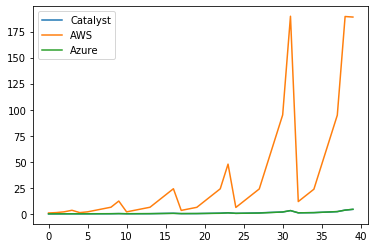

In [78]:
graph_pred([
        "Catalyst", "AWS", "Azure"
    ], [
        catalyst_y, aws_cata_price, azure_cata_price
    ])

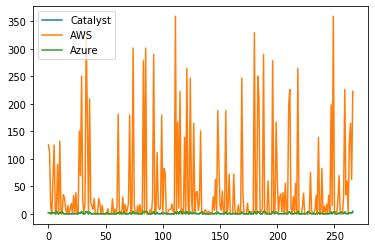

In [79]:
graph_pred([
        "Catalyst", "AWS", "Azure"
    ], [
        catalyst_aws_price,
        aws_y,
        azure_aws_price,
    ])

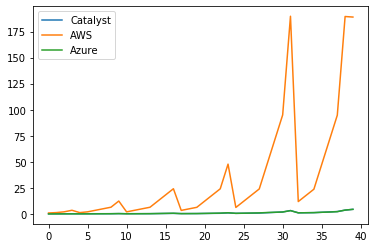

In [80]:
graph_pred([
        "Catalyst", "AWS", "Azure"
    ], [
        catalyst_azure_price,
        aws_azure_price,
        azure_y
    ])

In [81]:
def pred_save (origin_flavors, provider_names, predictions):
    
    flavor_data = origin_flavors[["Name", "vCPU", "RAM, GB", "HDD storage, GB", "SSD storage, GB"]]
    
    print(type(origin_flavors))
    
    for index, provider in enumerate(predictions):
        unit_string = ' price per hour, INR (ex GST)'
        company_name = provider_names[index]
        flavor_data[company_name + unit_string] = predictions[index]
    
    return flavor_data

In [82]:
final_cat_data = pred_save(
    catalyst_dataset,
    [
        "Catalyst", "AWS", "Azure"
    ], [
        catalyst_y, aws_cata_price, azure_cata_price
    ])

<class 'pandas.core.frame.DataFrame'>


In [83]:
final_aws_data = pred_save(
    aws_dataset,
    [
        "Catalyst", "AWS", "Azure"
    ], [
        catalyst_aws_price,
        aws_y,
        azure_aws_price,
    ])

<class 'pandas.core.frame.DataFrame'>


In [84]:
final_azure_data = pred_save(
    azure_dataset,
    [
        "Catalyst", "AWS", "Azure"
    ], [
        catalyst_azure_price,
        aws_azure_price,
        azure_y
    ])

<class 'pandas.core.frame.DataFrame'>


In [85]:
final_cat_data.to_csv('predicted-dataset/predicted_catalyst_prices.csv')

In [86]:
final_aws_data.to_csv('predicted-dataset/predicted_aws_prices.csv')

In [87]:
final_azure_data.to_csv('predicted-dataset/predicted_azure_prices.csv')

In [88]:
print('Saving resulting datasets.')

Saving resulting datasets.
